# 🔬 Semi-Supervised Learning for FDA Approval Prediction
## Drug Discovery with Limited Labeled Data

---

### 🎯 **Objective**
This notebook demonstrates **semi-supervised learning for FDA approval prediction** by:
- Training with **limited labeled molecules** (balanced FDA approved/not approved)
- Enhancing with **unlabeled molecules** from ZINC database
- Comparing performance against supervised baseline

### 💡 **Why This Matters**
In drug discovery:
- **Labeled data is EXPENSIVE**: FDA approval status requires clinical trials costing billions
- **Unlabeled data is ABUNDANT**: Millions of known molecular structures
- **Semi-supervised learning bridges this gap** by leveraging unlabeled data

### 📊 **Experimental Setup**
- **Target**: FDA_APPROVED (FDA approval status)
- **Labeled molecules**: From ClinTox dataset
- **Unlabeled Enhancement**: ZINC database molecules
- **Goal**: Predict which molecules are likely to be FDA approved

### 🧪 **Methods Evaluated**
1. **Baseline**: Supervised only (Random Forest)
2. **Label Propagation**: Graph-based, hard labels
3. **Label Spreading**: Graph-based, soft labels  
4. **Self-Training**: Iterative pseudo-labeling

---

**Expected Outcome**: Semi-supervised methods should leverage unlabeled data to improve prediction accuracy!

In [ ]:
# Cell 2: Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, cross_val_score
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    roc_auc_score, confusion_matrix, classification_report, 
    roc_curve, precision_recall_curve, average_precision_score
)
from sklearn.semi_supervised import LabelPropagation, LabelSpreading, SelfTrainingClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
import joblib
import json
import warnings
import os
from time import time
from collections import Counter
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Configure plotting
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10

print("=" * 100)
print("SEMI-SUPERVISED LEARNING FOR FDA APPROVAL PREDICTION")
print("Drug Discovery with Limited Labeled Data")
print("=" * 100)
print("\n✓ Libraries imported successfully")
print("✓ Random seed set to:", RANDOM_STATE)

SEMI-SUPERVISED LEARNING FOR FDA APPROVAL PREDICTION
Drug Discovery with Limited Labeled Data

✓ Libraries imported successfully
✓ Random seed set to: 42



STEP 1: LOADING PROCESSED DATA

✓ Labeled data: (234, 37)
✓ Unlabeled data: (249453, 36)
✓ Features: 36
✓ Target: FDA_APPROVED

🎯 FDA_APPROVED CLASS DISTRIBUTION

FDA_APPROVED:
  Class 0 (Not Approved): 94 (40.2%)
  Class 1 (FDA Approved): 140 (59.8%)


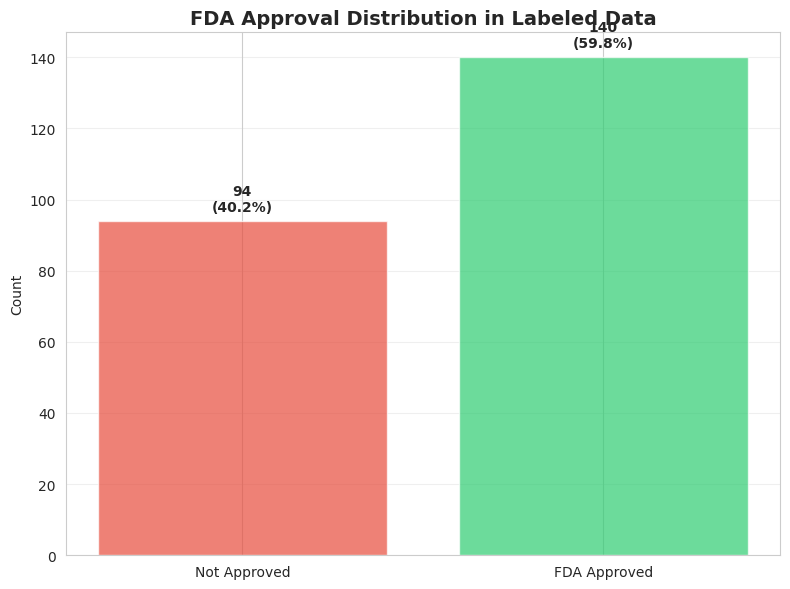

In [2]:
# Cell 3: Load processed data
print("\n" + "="*100)
print("STEP 1: LOADING PROCESSED DATA")
print("="*100)

# Load processed datasets
df_labeled = pd.read_csv('../../data/processed/drug_discovery/labeled_processed.csv')
df_unlabeled = pd.read_csv('../../data/processed/drug_discovery/unlabeled_processed.csv')

# Load feature info
with open('../../data/processed/drug_discovery/feature_info.json', 'r') as f:
    feature_info = json.load(f)

print(f"\n✓ Labeled data: {df_labeled.shape}")
print(f"✓ Unlabeled data: {df_unlabeled.shape}")
print(f"✓ Features: {feature_info['n_features']}")
print(f"✓ Target: {feature_info['target_variable']}")

# Display class distribution
print(f"\n{'='*100}")
print("🎯 FDA_APPROVED CLASS DISTRIBUTION")
print(f"{'='*100}")

fda_dist = df_labeled['FDA_APPROVED'].value_counts().sort_index()

print(f"\nFDA_APPROVED:")
print(f"  Class 0 (Not Approved): {fda_dist[0]} ({fda_dist[0]/len(df_labeled)*100:.1f}%)")
print(f"  Class 1 (FDA Approved): {fda_dist[1]} ({fda_dist[1]/len(df_labeled)*100:.1f}%)")

# Visualize
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
bars = ax.bar(['Not Approved', 'FDA Approved'], fda_dist.values, color=['#e74c3c', '#2ecc71'], alpha=0.7)
ax.set_ylabel('Count')
ax.set_title('FDA Approval Distribution in Labeled Data', fontweight='bold', fontsize=14)
for i, (bar, count) in enumerate(zip(bars, fda_dist.values)):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, 
            f'{count}\n({count/len(df_labeled)*100:.1f}%)', 
            ha='center', va='bottom', fontweight='bold')
ax.grid(alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

In [3]:
# Cell 4: Prepare data for training
print("\n" + "="*100)
print("STEP 2: PREPARING DATA FOR TRAINING")
print("="*100)

# Get feature columns (all except target)
feature_cols = [col for col in df_labeled.columns if col != 'FDA_APPROVED']

# Prepare labeled data
X_labeled = df_labeled[feature_cols].values
y_labeled = df_labeled['FDA_APPROVED'].values

# Prepare unlabeled data
X_unlabeled = df_unlabeled[feature_cols].values

print(f"\n✓ Labeled features shape: {X_labeled.shape}")
print(f"✓ Labeled target shape: {y_labeled.shape}")
print(f"✓ Unlabeled features shape: {X_unlabeled.shape}")

# Split labeled data into train and test sets (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X_labeled, y_labeled,
    test_size=0.3,
    random_state=RANDOM_STATE,
    stratify=y_labeled
)

# Use same unlabeled sizes as drug_discovery notebook
unlabeled_sizes = [0, 500, 1000, 2500, 5000, 10000]
unlabeled_sizes = [min(n, X_unlabeled.shape[0]) for n in unlabeled_sizes]

print(f"\n{'='*100}")
print("TRAIN/TEST SPLIT (Stratified)")
print(f"{'='*100}")
print(f"\nTraining set: {X_train.shape[0]} samples")
print(f"  - Not Approved: {(y_train == 0).sum()} ({(y_train == 0).sum()/len(y_train)*100:.1f}%)")
print(f"  - FDA Approved: {(y_train == 1).sum()} ({(y_train == 1).sum()/len(y_train)*100:.1f}%)")

print(f"\nTest set: {X_test.shape[0]} samples")
print(f"  - Not Approved: {(y_test == 0).sum()} ({(y_test == 0).sum()/len(y_test)*100:.1f}%)")
print(f"  - FDA Approved: {(y_test == 1).sum()} ({(y_test == 1).sum()/len(y_test)*100:.1f}%)")

print(f"\nUnlabeled pool: {X_unlabeled.shape[0]} samples")


STEP 2: PREPARING DATA FOR TRAINING



✓ Labeled features shape: (234, 36)
✓ Labeled target shape: (234,)
✓ Unlabeled features shape: (249453, 36)

TRAIN/TEST SPLIT (Stratified)

Training set: 163 samples
  - Not Approved: 65 (39.9%)
  - FDA Approved: 98 (60.1%)

Test set: 71 samples
  - Not Approved: 29 (40.8%)
  - FDA Approved: 42 (59.2%)

Unlabeled pool: 249453 samples


In [4]:
print("\n" + "="*100)
print("STEP 3: DEFINING HELPER FUNCTIONS")
print("="*100)

def evaluate_model(y_true, y_pred, y_pred_proba=None, model_name="Model"):
    """Comprehensive model evaluation with all key metrics"""
    metrics = {
        'Model': model_name,
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred, zero_division=0),
        'Recall': recall_score(y_true, y_pred, zero_division=0),
        'F1-Score': f1_score(y_true, y_pred, zero_division=0),
    }
    
    if y_pred_proba is not None:
        try:
            # Check if we have valid probability scores (not all binary)
            unique_probs = np.unique(y_pred_proba)
            if len(unique_probs) > 2 and not np.all((y_pred_proba == 0) | (y_pred_proba == 1)):
                metrics['ROC-AUC'] = roc_auc_score(y_true, y_pred_proba)
                metrics['PR-AUC'] = average_precision_score(y_true, y_pred_proba)
            else:
                # Binary predictions only - can't compute ROC-AUC meaningfully
                metrics['ROC-AUC'] = np.nan
                metrics['PR-AUC'] = np.nan
        except:
            metrics['ROC-AUC'] = np.nan
            metrics['PR-AUC'] = np.nan
    else:
        metrics['ROC-AUC'] = np.nan
        metrics['PR-AUC'] = np.nan
    
    return metrics


def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix", labels=['Non-Toxic', 'Toxic']):
    """Plot confusion matrix heatmap"""
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(7, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
                xticklabels=labels, yticklabels=labels,
                annot_kws={'size': 14, 'weight': 'bold'})
    plt.xlabel('Predicted', fontsize=12, fontweight='bold')
    plt.ylabel('Actual', fontsize=12, fontweight='bold')
    plt.title(title, fontsize=14, fontweight='bold', pad=15)
    
    # Add percentages
    total = cm.sum()
    for i in range(2):
        for j in range(2):
            plt.text(j+0.5, i+0.7, f'({cm[i,j]/total*100:.1f}%)', 
                    ha='center', va='center', fontsize=10, color='gray')
    
    plt.tight_layout()
    plt.show()
    
    return cm


print("\n✓ Helper functions defined:")
print("  - evaluate_model(): Compute accuracy, precision, recall, F1, ROC-AUC, PR-AUC")
print("  - plot_confusion_matrix(): Visualize classification results")


STEP 3: DEFINING HELPER FUNCTIONS

✓ Helper functions defined:
  - evaluate_model(): Compute accuracy, precision, recall, F1, ROC-AUC, PR-AUC
  - plot_confusion_matrix(): Visualize classification results



STEP 4: BASELINE - SUPERVISED LEARNING ONLY

🔹 Training Random Forest (supervised baseline)...

BASELINE PERFORMANCE (Supervised Only)
Accuracy:  0.7324
Precision: 0.7674
Recall:    0.7857
F1-Score:  0.7765
ROC-AUC:   0.8231
Training Time: 0.18s


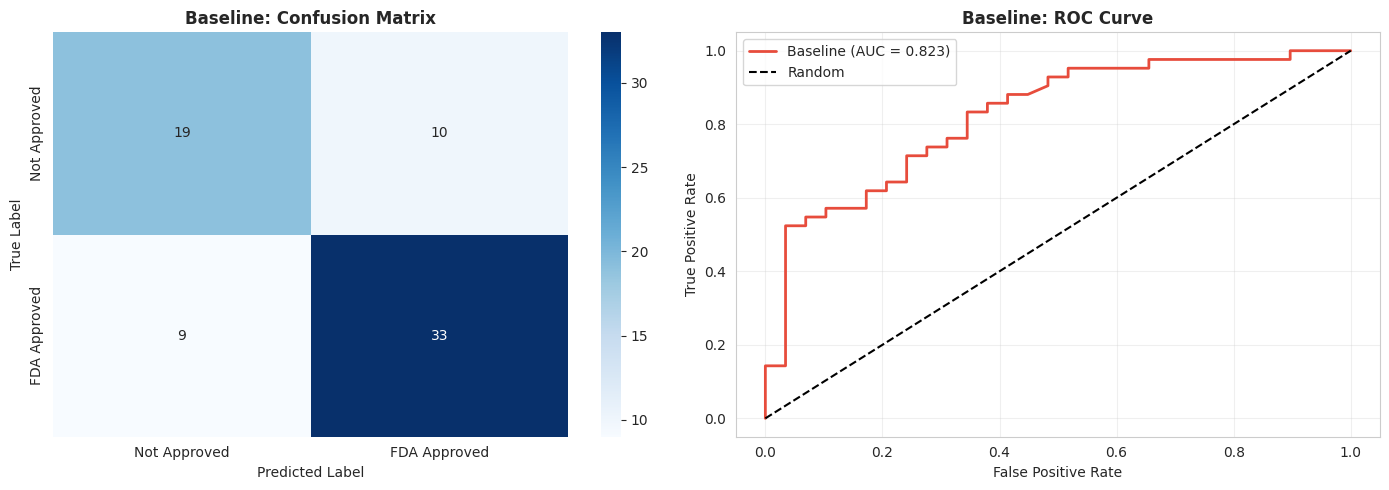

In [5]:
print("\n" + "="*100)
print("STEP 4: BASELINE - SUPERVISED LEARNING ONLY")
print("="*100)

# Train Random Forest on labeled data only
print("\n🔹 Training Random Forest (supervised baseline)...")
baseline_rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=RANDOM_STATE,
    class_weight='balanced',
    n_jobs=-1
)

start_time = time()
baseline_rf.fit(X_train, y_train)
training_time = time() - start_time

# Predictions
y_pred_baseline = baseline_rf.predict(X_test)
y_proba_baseline = baseline_rf.predict_proba(X_test)[:, 1]

# --- MODIFIED: Use the helper function for consistency ---
baseline_metrics = evaluate_model(
    y_test, 
    y_pred_baseline, 
    y_proba_baseline, 
    model_name="Baseline (Supervised)"
)

# Add training time manually since evaluate_model doesn't track it
baseline_metrics['Training_Time'] = training_time

print(f"\n{'='*100}")
print("BASELINE PERFORMANCE (Supervised Only)")
print(f"{'='*100}")
print(f"Accuracy:  {baseline_metrics['Accuracy']:.4f}")
print(f"Precision: {baseline_metrics['Precision']:.4f}")
print(f"Recall:    {baseline_metrics['Recall']:.4f}")
print(f"F1-Score:  {baseline_metrics['F1-Score']:.4f}")
print(f"ROC-AUC:   {baseline_metrics['ROC-AUC']:.4f}")
print(f"Training Time: {baseline_metrics['Training_Time']:.2f}s")

# Visualize Results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. Confusion Matrix
cm_baseline = confusion_matrix(y_test, y_pred_baseline)
sns.heatmap(cm_baseline, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Not Approved', 'FDA Approved'],
            yticklabels=['Not Approved', 'FDA Approved'])
axes[0].set_title('Baseline: Confusion Matrix', fontweight='bold')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

# 2. ROC Curve
if not np.isnan(baseline_metrics['ROC-AUC']):
    fpr, tpr, _ = roc_curve(y_test, y_proba_baseline)
    axes[1].plot(fpr, tpr, label=f'Baseline (AUC = {baseline_metrics["ROC-AUC"]:.3f})', linewidth=2, color='#e74c3c')
    axes[1].plot([0, 1], [0, 1], 'k--', label='Random')
    axes[1].set_xlabel('False Positive Rate')
    axes[1].set_ylabel('True Positive Rate')
    axes[1].set_title('Baseline: ROC Curve', fontweight='bold')
    axes[1].legend()
    axes[1].grid(alpha=0.3)
else:
    axes[1].text(0.5, 0.5, "ROC-AUC Not Available", ha='center')

plt.tight_layout()
plt.show()

In [6]:
# Cell 6: Label Propagation (Graph-based, Hard Labels)
print("\n" + "="*100)
print("STEP 5: LABEL PROPAGATION (Graph-Based SSL with Hard Labels)")
print("="*100)

results_lp = []

# HEURISTIC: Calculate optimal gamma based on feature count
# This is crucial for RBF to work. Hardcoded 0.1 or 20 will break the graph.
n_features = X_train.shape[1]
optimal_gamma = 1.0 / n_features

for n_unlabeled in unlabeled_sizes:
    print(f"\n{'='*100}")
    print(f"Testing with {n_unlabeled:,} unlabeled samples")
    print(f"{'='*100}")
    
    if n_unlabeled == 0:
        # Use baseline results
        baseline_res = baseline_metrics.copy()
        baseline_res['Method'] = 'Label Propagation'
        baseline_res['N_Unlabeled'] = 0
        results_lp.append(baseline_res)
        print("✓ Using baseline results (0 unlabeled)")
        continue
    
    # Sample unlabeled data
    # Ensure we don't sample more than available
    current_n = min(n_unlabeled, X_unlabeled.shape[0])
    indices = np.random.choice(X_unlabeled.shape[0], current_n, replace=False)
    X_unlab_sample = X_unlabeled[indices]
    
    # Combine labeled and unlabeled
    X_combined = np.vstack([X_train, X_unlab_sample])
    y_combined = np.concatenate([y_train, np.full(current_n, -1)])
    
    print(f"Combined: {X_combined.shape[0]} total ({len(y_train)} labeled + {current_n} unlabeled)")
    
    # Train Label Propagation (FORCED RBF KERNEL)
    print(f"🔹 Training Label Propagation (RBF Kernel, gamma={optimal_gamma:.4f})...")
    
    lp = LabelPropagation(
        kernel='rbf', 
        gamma=optimal_gamma,  # Optimized gamma
        max_iter=100, 
        n_jobs=-1
    )
    
    start_time = time()
    lp.fit(X_combined, y_combined)
    lp_time = time() - start_time
    
    # Prediction
    y_pred_lp = lp.predict(X_test)
    
    # --- PROBABILITY SAFETY CHECK ---
    try:
        y_proba_lp = lp.predict_proba(X_test)[:, 1]
        
        # Check for NaNs (disconnected nodes)
        n_nans = np.isnan(y_proba_lp).sum()
        if n_nans > 0:
            print(f"   ⚠️ Warning: Found {n_nans} NaN probabilities. Filling with 0.5 (uncertain).")
            y_proba_lp = np.nan_to_num(y_proba_lp, nan=0.5)
            
    except Exception as e:
        print(f"   ⚠️ Probability calculation failed: {e}")
        y_proba_lp = None
    
    # Use helper function
    metrics = evaluate_model(
        y_test, 
        y_pred_lp, 
        y_proba_lp, 
        model_name=f"Label Propagation (n={current_n})"
    )
    
    # Add metadata
    metrics['Method'] = 'Label Propagation'
    metrics['N_Unlabeled'] = current_n
    metrics['Training_Time'] = lp_time
    
    results_lp.append(metrics)
    
    # Print formatted result
    roc_str = f"{metrics['ROC-AUC']:.4f}" if not np.isnan(metrics['ROC-AUC']) else "N/A"
    print(f"   F1: {metrics['F1-Score']:.4f} | ROC-AUC: {roc_str} | Time: {lp_time:.2f}s")

# Summary DataFrame
results_lp_df = pd.DataFrame(results_lp)
print(f"\n{'='*100}")
print("LABEL PROPAGATION RESULTS")
print(f"{'='*100}")
# Ensure we map the metric names correctly (Helper uses 'F1-Score', previous code used 'f1')
cols_to_show = ['Method', 'N_Unlabeled', 'Accuracy', 'F1-Score', 'ROC-AUC']
print(results_lp_df[cols_to_show].to_string(index=False))


STEP 5: LABEL PROPAGATION (Graph-Based SSL with Hard Labels)

Testing with 0 unlabeled samples
✓ Using baseline results (0 unlabeled)

Testing with 500 unlabeled samples
Combined: 663 total (163 labeled + 500 unlabeled)
🔹 Training Label Propagation (RBF Kernel, gamma=0.0278)...
   F1: 0.7500 | ROC-AUC: 0.8087 | Time: 0.02s

Testing with 1,000 unlabeled samples
Combined: 1163 total (163 labeled + 1000 unlabeled)
🔹 Training Label Propagation (RBF Kernel, gamma=0.0278)...
   F1: 0.7434 | ROC-AUC: 0.8091 | Time: 0.04s

Testing with 2,500 unlabeled samples
Combined: 2663 total (163 labeled + 2500 unlabeled)
🔹 Training Label Propagation (RBF Kernel, gamma=0.0278)...
   F1: 0.7434 | ROC-AUC: 0.8087 | Time: 0.45s

Testing with 5,000 unlabeled samples
Combined: 5163 total (163 labeled + 5000 unlabeled)
🔹 Training Label Propagation (RBF Kernel, gamma=0.0278)...
   F1: 0.7434 | ROC-AUC: 0.8103 | Time: 1.64s

Testing with 10,000 unlabeled samples
Combined: 10163 total (163 labeled + 10000 unlabel

In [7]:
# Cell 7: Label Spreading (Graph-based, Soft Labels)
print("\n" + "="*100)
print("STEP 6: LABEL SPREADING (Graph-Based SSL with Soft Labels)")
print("="*100)

results_ls = []

# HEURISTIC: Calculate optimal gamma based on feature count
n_features = X_train.shape[1]
optimal_gamma = 1.0 / n_features

for n_unlabeled in unlabeled_sizes:
    print(f"\n{'='*100}")
    print(f"Testing with {n_unlabeled:,} unlabeled samples")
    print(f"{'='*100}")
    
    if n_unlabeled == 0:
        # Use baseline results
        baseline_res = baseline_metrics.copy()
        baseline_res['Method'] = 'Label Spreading'
        baseline_res['N_Unlabeled'] = 0
        results_ls.append(baseline_res)
        print("✓ Using baseline results (0 unlabeled)")
        continue
    
    # Sample unlabeled data
    # Ensure we don't sample more than available
    current_n = min(n_unlabeled, X_unlabeled.shape[0])
    indices = np.random.choice(X_unlabeled.shape[0], current_n, replace=False)
    X_unlab_sample = X_unlabeled[indices]
    
    # Combine labeled and unlabeled
    X_combined = np.vstack([X_train, X_unlab_sample])
    y_combined = np.concatenate([y_train, np.full(current_n, -1)])
    
    print(f"Combined: {X_combined.shape[0]} total ({len(y_train)} labeled + {current_n} unlabeled)")
    
    # --- MEMORY SAFETY CHECK ---
    total_samples = X_combined.shape[0]
    if total_samples > 10000:
        print(f"🔹 Large dataset detected ({total_samples}). Switching to kernel='knn' to save RAM.")
        kernel_type = 'knn'
        gamma_val = 20 # Placeholder for KNN
    else:
        print(f"🔹 Using RBF kernel (gamma={optimal_gamma:.4f})...")
        kernel_type = 'rbf'
        gamma_val = optimal_gamma

    # Train Label Spreading
    ls = LabelSpreading(
        kernel=kernel_type, 
        gamma=gamma_val, 
        n_neighbors=7, # Used if kernel='knn'
        alpha=0.2,     # Soft clamping factor
        max_iter=100, 
        n_jobs=-1
    )
    
    start_time = time()
    ls.fit(X_combined, y_combined)
    ls_time = time() - start_time
    
    # Prediction
    y_pred_ls = ls.predict(X_test)
    
    # --- CRITICAL FIX FOR NAN PROBABILITIES ---
    try:
        y_proba_ls = ls.predict_proba(X_test)[:, 1]
        
        # Check for NaNs (disconnected nodes in graph)
        n_nans = np.isnan(y_proba_ls).sum()
        if n_nans > 0:
            print(f"   ⚠️ Warning: Found {n_nans} NaN probabilities. Filling with 0.5 (uncertain).")
            # Fill NaNs with 0.5 (neutral probability) so ROC-AUC doesn't crash
            y_proba_ls = np.nan_to_num(y_proba_ls, nan=0.5)
            
    except Exception as e:
        print(f"   ⚠️ Probability calculation failed: {e}")
        y_proba_ls = None

    # Use the helper function for consistent metrics
    metrics = evaluate_model(
        y_test, 
        y_pred_ls, 
        y_proba_ls, 
        model_name=f"Label Spreading (n={current_n})"
    )
    
    # Add custom fields
    metrics['Method'] = 'Label Spreading'
    metrics['N_Unlabeled'] = current_n
    metrics['Training_Time'] = ls_time
    
    results_ls.append(metrics)
    
    # Print formatted result
    roc_str = f"{metrics['ROC-AUC']:.4f}" if not np.isnan(metrics['ROC-AUC']) else "N/A"
    print(f"   F1: {metrics['F1-Score']:.4f} | ROC-AUC: {roc_str} | Time: {ls_time:.2f}s")

# Summary DataFrame
results_ls_df = pd.DataFrame(results_ls)
print(f"\n{'='*100}")
print("LABEL SPREADING RESULTS")
print(f"{'='*100}")
# Select columns that actually exist in the metrics
cols_to_show = ['Method', 'N_Unlabeled', 'Accuracy', 'F1-Score', 'ROC-AUC']
print(results_ls_df[cols_to_show].to_string(index=False))


STEP 6: LABEL SPREADING (Graph-Based SSL with Soft Labels)

Testing with 0 unlabeled samples
✓ Using baseline results (0 unlabeled)

Testing with 500 unlabeled samples
Combined: 663 total (163 labeled + 500 unlabeled)
🔹 Using RBF kernel (gamma=0.0278)...
   F1: 0.7500 | ROC-AUC: 0.8157 | Time: 0.01s

Testing with 1,000 unlabeled samples
Combined: 1163 total (163 labeled + 1000 unlabeled)
🔹 Using RBF kernel (gamma=0.0278)...
   F1: 0.7434 | ROC-AUC: 0.8177 | Time: 0.03s

Testing with 2,500 unlabeled samples
Combined: 2663 total (163 labeled + 2500 unlabeled)
🔹 Using RBF kernel (gamma=0.0278)...
   F1: 0.7434 | ROC-AUC: 0.8206 | Time: 0.14s

Testing with 5,000 unlabeled samples
Combined: 5163 total (163 labeled + 5000 unlabeled)
🔹 Using RBF kernel (gamma=0.0278)...
   F1: 0.7434 | ROC-AUC: 0.8214 | Time: 0.55s

Testing with 10,000 unlabeled samples
Combined: 10163 total (163 labeled + 10000 unlabeled)
🔹 Large dataset detected (10163). Switching to kernel='knn' to save RAM.
   ⚠️ Warning

In [8]:
# Cell 8: Self-Training (Iterative Pseudo-Labeling)
print("\n" + "="*100)
print("STEP 7: SELF-TRAINING (Iterative Pseudo-Labeling)")
print("="*100)

results_st = []

for n_unlabeled in unlabeled_sizes:
    print(f"\n{'='*100}")
    print(f"Testing with {n_unlabeled:,} unlabeled samples")
    print(f"{'='*100}")
    
    if n_unlabeled == 0:
        # Use baseline results
        baseline_res = baseline_metrics.copy()
        baseline_res['Method'] = 'Self-Training'
        baseline_res['N_Unlabeled'] = 0
        baseline_res['N_Pseudo_Labeled'] = 0
        results_st.append(baseline_res)
        print("✓ Using baseline results (0 unlabeled)")
        continue
    
    # Sample unlabeled data
    # Ensure we don't sample more than available
    current_n = min(n_unlabeled, X_unlabeled.shape[0])
    indices = np.random.choice(X_unlabeled.shape[0], current_n, replace=False)
    X_unlab_sample = X_unlabeled[indices]
    
    # Combine labeled and unlabeled
    X_combined = np.vstack([X_train, X_unlab_sample])
    y_combined = np.concatenate([y_train, np.full(current_n, -1)])
    
    print(f"Combined: {X_combined.shape[0]} total ({len(y_train)} labeled + {current_n} unlabeled)")
    
    # Train Self-Training
    print("🔹 Training Self-Training (Random Forest, threshold=0.75)...")
    st = SelfTrainingClassifier(
        RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1),
        threshold=0.75, max_iter=10
    )
    
    start_time = time()
    st.fit(X_combined, y_combined)
    st_time = time() - start_time
    
    # Check how many were pseudo-labeled
    n_pseudo_labeled = (st.transduction_ != -1).sum() - len(y_train)
    print(f"   📝 Pseudo-labeled {n_pseudo_labeled}/{current_n} samples ({n_pseudo_labeled/current_n*100:.1f}%)")
    
    # Predict
    y_pred_st = st.predict(X_test)
    y_proba_st = st.predict_proba(X_test)[:, 1]
    
    # Use helper function
    metrics = evaluate_model(y_test, y_pred_st, y_proba_st, f"Self-Training (n={current_n})")
    
    # Add custom metadata
    metrics['Method'] = 'Self-Training'
    metrics['N_Unlabeled'] = current_n
    metrics['N_Pseudo_Labeled'] = n_pseudo_labeled
    metrics['Training_Time'] = st_time
    
    results_st.append(metrics)
    
    # Print formatted result (using Title Case keys from helper)
    roc_str = f"{metrics['ROC-AUC']:.4f}" if not np.isnan(metrics['ROC-AUC']) else "N/A"
    print(f"   F1: {metrics['F1-Score']:.4f} | ROC-AUC: {roc_str} | Time: {st_time:.2f}s")

# Summary DataFrame
results_st_df = pd.DataFrame(results_st)
print(f"\n{'='*100}")
print("SELF-TRAINING RESULTS")
print(f"{'='*100}")
# Ensure consistent column names
cols_to_show = ['Method', 'N_Unlabeled', 'N_Pseudo_Labeled', 'Accuracy', 'F1-Score', 'ROC-AUC']
print(results_st_df[cols_to_show].to_string(index=False))


STEP 7: SELF-TRAINING (Iterative Pseudo-Labeling)

Testing with 0 unlabeled samples
✓ Using baseline results (0 unlabeled)

Testing with 500 unlabeled samples
Combined: 663 total (163 labeled + 500 unlabeled)
🔹 Training Self-Training (Random Forest, threshold=0.75)...
   📝 Pseudo-labeled 440/500 samples (88.0%)
   F1: 0.7595 | ROC-AUC: 0.8173 | Time: 2.54s

Testing with 1,000 unlabeled samples
Combined: 1163 total (163 labeled + 1000 unlabeled)
🔹 Training Self-Training (Random Forest, threshold=0.75)...
   📝 Pseudo-labeled 925/1000 samples (92.5%)
   F1: 0.8193 | ROC-AUC: 0.8173 | Time: 2.68s

Testing with 2,500 unlabeled samples
Combined: 2663 total (163 labeled + 2500 unlabeled)
🔹 Training Self-Training (Random Forest, threshold=0.75)...
   📝 Pseudo-labeled 2273/2500 samples (90.9%)
   F1: 0.7711 | ROC-AUC: 0.7812 | Time: 2.97s

Testing with 5,000 unlabeled samples
Combined: 5163 total (163 labeled + 5000 unlabeled)
🔹 Training Self-Training (Random Forest, threshold=0.75)...
   📝 Ps

In [9]:
print("\n" + "="*100)
print("STEP 8: ROBUST CO-TRAINING (Full Feature Set & Multi-View)")
print("="*100)

# ------------------------------------------------------------------------------
# 1. COMPREHENSIVE VIEW SPLITTING
# ------------------------------------------------------------------------------
# View 1: Physicochemical, Electronic, and "Global" properties
view1_candidates = [
    'MolWt', 'LogP', 'NumHDonors', 'NumHAcceptors', 'NumValenceElectrons', 
    'TPSA', 'MaxPartialCharge', 'MinPartialCharge', 'LabuteASA', 'MolMR', 
    'QED', 'NumHeteroatoms'
]

# View 2: Topology, Connectivity, Complexity, Rings, and Fragments
view2_candidates = [
    'NumRotatableBonds', 'NumAromaticRings', 'NumRings', 'NumAliphaticRings', 
    'NumSaturatedRings', 'FractionCsp3', 'PEOE_VSA1', 'PEOE_VSA2', 'BertzCT', 
    'Chi0v', 'Chi1v', 'Kappa1', 'Kappa2', 'BalabanJ', 'HallKierAlpha', 
    'NumSaturatedCarbocycles', 'NumAromaticCarbocycles', 
    'NumSaturatedHeterocycles', 'NumAromaticHeterocycles', 
    'fr_NH2', 'fr_COO', 'fr_benzene', 'fr_furan', 'fr_halogen'
]

# Map to indices based on your actual feature_cols
view1_features = [f for f in view1_candidates if f in feature_cols]
view2_features = [f for f in view2_candidates if f in feature_cols]

# Safety fallback: if mapping fails, split features in half
if len(view1_features) < 3 or len(view2_features) < 3:
    print("⚠️  Warning: Feature mapping low, reverting to simple split.")
    mid = len(feature_cols) // 2
    view1_features = feature_cols[:mid]
    view2_features = feature_cols[mid:]

v1_idx = [feature_cols.index(f) for f in view1_features]
v2_idx = [feature_cols.index(f) for f in view2_features]

print(f"\nView 1 (Physicochemical): {len(view1_features)} features")
print(f"  Example: {view1_features[:3]}...")
print(f"View 2 (Structural/Graph): {len(view2_features)} features")
print(f"  Example: {view2_features[:3]}...")

# ------------------------------------------------------------------------------
# 2. Hyperparameters
# ------------------------------------------------------------------------------
MAX_ITERATIONS = 20
SAMPLES_PER_ITER = 50       # How many samples to add per loop
CONFIDENCE_THRESHOLD = 0.80 # Minimum confidence to trust a pseudo-label

results_ct = []

# Ensure we test baseline (0) and then the unlabeled sizes
test_sizes = [0] + unlabeled_sizes

for idx, n_unlabeled in enumerate(test_sizes):
    print(f"\n{'='*80}")
    if n_unlabeled == 0:
        print(f"BASELINE: Supervised Learning (Original Labels Only)")
    else:
        print(f"CO-TRAINING: With {n_unlabeled:,} Unlabeled Samples")
    print(f"{'='*80}")
    
    # --- INITIALIZATION ---
    # Start with original labeled data
    X_train_v1 = X_train[:, v1_idx]
    X_train_v2 = X_train[:, v2_idx]
    y_train_curr = y_train.copy()
    
    # Initialize classifiers with balanced weights
    clf1 = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, class_weight='balanced')
    clf2 = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, class_weight='balanced')
    
    start_time = time()
    
    # --- BASELINE CASE (No Loop) ---
    if n_unlabeled == 0:
        clf1.fit(X_train_v1, y_train_curr)
        clf2.fit(X_train_v2, y_train_curr)
        
        # Ensemble Predict
        p1 = clf1.predict_proba(X_test[:, v1_idx])[:, 1]
        p2 = clf2.predict_proba(X_test[:, v2_idx])[:, 1]
        y_prob = (p1 + p2) / 2
        y_pred = (y_prob >= 0.5).astype(int)
        
        # Use helper function
        metrics = evaluate_model(y_test, y_pred, y_prob, "Baseline (n=0)")
        metrics['Method'] = 'Co-Training'
        metrics['N_Unlabeled'] = 0
        metrics['Final_Train_Size'] = len(y_train_curr)
        results_ct.append(metrics)
        print(f"  >>> Baseline ROC-AUC: {metrics['ROC-AUC']:.4f} | F1: {metrics['F1-Score']:.4f}")
        continue

    # --- CO-TRAINING LOOP ---
    # Prepare the pool of unlabeled data
    current_unlabeled = X_unlabeled[:n_unlabeled]    
    X_pool_v1 = current_unlabeled[:, v1_idx]
    X_pool_v2 = current_unlabeled[:, v2_idx]
    
    # Mask to track available samples (True = available to be labeled)
    mask_avail = np.ones(n_unlabeled, dtype=bool)
    
    print(f"  [Start] Labeled: {len(y_train_curr)} | Unlabeled Pool: {n_unlabeled}")

    for i in range(MAX_ITERATIONS):
        if not np.any(mask_avail): break
            
        # A. Train both models on current labeled set
        clf1.fit(X_train_v1, y_train_curr)
        clf2.fit(X_train_v2, y_train_curr)
        
        # B. Predict on the REMAINING unlabeled pool
        pool_subset_v1 = X_pool_v1[mask_avail]
        pool_subset_v2 = X_pool_v2[mask_avail]
        
        if len(pool_subset_v1) == 0: break
            
        prob1 = clf1.predict_proba(pool_subset_v1)
        prob2 = clf2.predict_proba(pool_subset_v2)
        
        # C. Select High-Confidence Samples
        # Helper to get indices of high confidence predictions
        def get_high_conf_samples(probs):
            conf = np.max(probs, axis=1)
            pred = np.argmax(probs, axis=1)
            # Filter by threshold
            mask = conf > CONFIDENCE_THRESHOLD
            # Sort by confidence (descending)
            indices = np.where(mask)[0]
            sorted_indices = indices[np.argsort(conf[indices])[::-1]]
            return sorted_indices[:SAMPLES_PER_ITER], pred[sorted_indices[:SAMPLES_PER_ITER]]

        # Model 1 teaches
        idx1, lbl1 = get_high_conf_samples(prob1)
        # Model 2 teaches
        idx2, lbl2 = get_high_conf_samples(prob2)
        
        # Map pool subset indices back to original pool indices
        current_indices = np.where(mask_avail)[0]
        
        candidates_idx = []
        candidates_lbl = []
        
        # Collect candidates from Model 1
        for local_idx, label in zip(idx1, lbl1):
            candidates_idx.append(current_indices[local_idx])
            candidates_lbl.append(label)
            
        # Collect candidates from Model 2
        for local_idx, label in zip(idx2, lbl2):
            candidates_idx.append(current_indices[local_idx])
            candidates_lbl.append(label)
            
        if not candidates_idx:
            if i == 0: print("  Warning: No confident samples found in first iteration.")
            break
            
        # D. Add Unique Pseudo-Labels to Training Set
        new_idx = np.array(candidates_idx)
        new_lbl = np.array(candidates_lbl)
        
        # Remove duplicates (if both models picked the same sample)
        unique_idx, u_pos = np.unique(new_idx, return_index=True)
        final_idx = unique_idx
        final_lbl = new_lbl[u_pos]
        
        # Append features
        X_add_v1 = current_unlabeled[final_idx][:, v1_idx]
        X_add_v2 = current_unlabeled[final_idx][:, v2_idx]
        
        X_train_v1 = np.vstack((X_train_v1, X_add_v1))
        X_train_v2 = np.vstack((X_train_v2, X_add_v2))
        y_train_curr = np.concatenate((y_train_curr, final_lbl))
        
        # Mark as used
        mask_avail[final_idx] = False
        
        if (i+1) % 5 == 0 or i == 0:
             print(f"  Iter {i+1}: Added {len(final_lbl)} samples. (Total Train: {len(y_train_curr)})")

    # --- FINAL EVALUATION ---
    # Train on final augmented dataset
    clf1.fit(X_train_v1, y_train_curr)
    clf2.fit(X_train_v2, y_train_curr)
    
    train_time = time() - start_time
    
    # Predict
    p1 = clf1.predict_proba(X_test[:, v1_idx])[:, 1]
    p2 = clf2.predict_proba(X_test[:, v2_idx])[:, 1]
    y_prob = (p1 + p2) / 2
    y_pred = (y_prob >= 0.5).astype(int)
    
    # Use helper function
    metrics = evaluate_model(y_test, y_pred, y_prob, f"CoTrain(n={n_unlabeled})")
    metrics['Method'] = 'Co-Training'
    metrics['N_Unlabeled'] = n_unlabeled
    metrics['Final_Train_Size'] = len(y_train_curr)
    metrics['Training_Time'] = train_time
    results_ct.append(metrics)
    
    print(f"  >>> Result ROC-AUC: {metrics['ROC-AUC']:.4f} | F1: {metrics['F1-Score']:.4f}")

# Final Summary Table
results_ct_df = pd.DataFrame(results_ct)
print(f"\n{'='*100}")
print("CO-TRAINING FINAL RESULTS")
print(f"{'='*100}")
# Select columns ensuring names match keys in evaluate_model (Title Case)
cols_to_show = ['N_Unlabeled', 'Final_Train_Size', 'Accuracy', 'F1-Score', 'ROC-AUC']
print(results_ct_df[cols_to_show].to_string(index=False))


STEP 8: ROBUST CO-TRAINING (Full Feature Set & Multi-View)

View 1 (Physicochemical): 12 features
  Example: ['MolWt', 'LogP', 'NumHDonors']...
View 2 (Structural/Graph): 24 features
  Example: ['NumRotatableBonds', 'NumAromaticRings', 'NumRings']...

BASELINE: Supervised Learning (Original Labels Only)
  >>> Baseline ROC-AUC: 0.8087 | F1: 0.7952

BASELINE: Supervised Learning (Original Labels Only)
  >>> Baseline ROC-AUC: 0.8087 | F1: 0.7952

CO-TRAINING: With 500 Unlabeled Samples
  [Start] Labeled: 163 | Unlabeled Pool: 500
  Iter 1: Added 84 samples. (Total Train: 247)
  Iter 5: Added 74 samples. (Total Train: 570)
  Iter 10: Added 1 samples. (Total Train: 628)
  >>> Result ROC-AUC: 0.7874 | F1: 0.8352

CO-TRAINING: With 1,000 Unlabeled Samples
  [Start] Labeled: 163 | Unlabeled Pool: 1000
  Iter 1: Added 89 samples. (Total Train: 252)
  Iter 5: Added 90 samples. (Total Train: 609)
  Iter 10: Added 78 samples. (Total Train: 1026)
  Iter 15: Added 2 samples. (Total Train: 1146)
  >


STEP 9: COMBINING ALL RESULTS

ALL METHODS COMPARISON (Sorted by F1-Score)
           Method  N_Unlabeled  Accuracy  Precision   Recall  F1-Score  ROC-AUC
      Co-Training          500  0.788732   0.775510 0.904762  0.835165 0.787356
    Self-Training         5000  0.802817   0.833333 0.833333  0.833333 0.811576
    Self-Training        10000  0.788732   0.813953 0.833333  0.823529 0.794745
    Self-Training         1000  0.788732   0.829268 0.809524  0.819277 0.817323
      Co-Training         2500  0.746479   0.714286 0.952381  0.816327 0.766010
      Co-Training         1000  0.718310   0.696429 0.928571  0.795918 0.731117
      Co-Training            0  0.760563   0.804878 0.785714  0.795181 0.808703
      Co-Training            0  0.760563   0.804878 0.785714  0.795181 0.808703
      Co-Training        10000  0.718310   0.703704 0.904762  0.791667 0.779146
      Co-Training         5000  0.704225   0.690909 0.904762  0.783505 0.780378
Label Propagation            0  0.732394   0

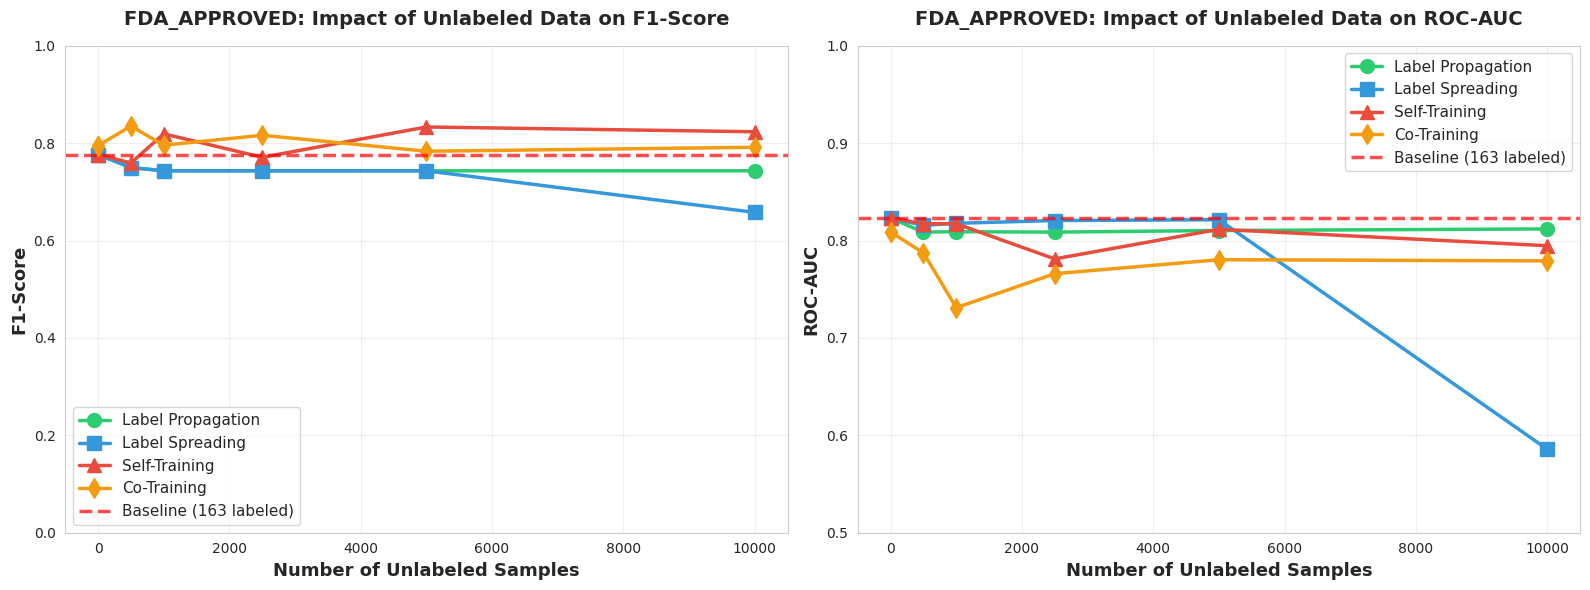


✓ Learning curves saved to: ../../data/predictions/drug_discovery/fda_learning_curves.png


In [10]:
# Cell 10: Combine and Compare All Methods
print("\n" + "="*100)
print("STEP 9: COMBINING ALL RESULTS")
print("="*100)

# Combine all results into one DataFrame
all_results = pd.concat([results_lp_df, results_ls_df, results_st_df, results_ct_df], ignore_index=True)

# Sort by F1-Score (Title Case)
all_results_sorted = all_results.sort_values('F1-Score', ascending=False)

print(f"\n{'='*100}")
print("ALL METHODS COMPARISON (Sorted by F1-Score)")
print(f"{'='*100}")
# Display key metrics
display_cols = ['Method', 'N_Unlabeled', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
print(all_results_sorted[display_cols].to_string(index=False))

# Best model analysis
best_model = all_results_sorted.iloc[0]
print(f"\n{'='*100}")
print("🏆 BEST PERFORMING MODEL")
print(f"{'='*100}")
print(f"Method:      {best_model['Method']}")
print(f"N_Unlabeled: {int(best_model['N_Unlabeled']):,}")
print(f"Accuracy:    {best_model['Accuracy']:.4f}")
print(f"F1-Score:    {best_model['F1-Score']:.4f}")
print(f"ROC-AUC:     {best_model['ROC-AUC']:.4f}")

# Improvement over baseline
# Note: Ensure baseline_metrics also uses Title Case keys if generated by evaluate_model
baseline_f1 = baseline_metrics['F1-Score']
improvement = ((best_model['F1-Score'] - baseline_f1) / baseline_f1) * 100
print(f"\n💪 Improvement over baseline: {improvement:+.2f}%")


# Cell 11: Visualizing Learning Curves
print("\n" + "="*100)
print("STEP 10: VISUALIZING LEARNING CURVES")
print("="*100)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Prepare data for plotting
methods = {
    'Label Propagation': results_lp_df,
    'Label Spreading': results_ls_df,
    'Self-Training': results_st_df,
    'Co-Training': results_ct_df
}

colors = ['#2ecc71', '#3498db', '#e74c3c', '#f39c12']
markers = ['o', 's', '^', 'd']

# FDA_APPROVED - F1 Score
for idx, (method_name, df) in enumerate(methods.items()):
    if len(df) > 0:
        # Using Title Case 'F1-Score'
        axes[0].plot(df['N_Unlabeled'], df['F1-Score'], 
                    marker=markers[idx], linewidth=2.5, markersize=10,
                    label=method_name, color=colors[idx])

axes[0].axhline(y=baseline_metrics['F1-Score'], color='red', linestyle='--', linewidth=2.5, 
               label=f'Baseline ({len(X_train)} labeled)', alpha=0.7)
axes[0].set_xlabel('Number of Unlabeled Samples', fontsize=13, fontweight='bold')
axes[0].set_ylabel('F1-Score', fontsize=13, fontweight='bold')
axes[0].set_title('FDA_APPROVED: Impact of Unlabeled Data on F1-Score', 
                fontsize=14, fontweight='bold', pad=15)
axes[0].legend(loc='best', fontsize=11)
axes[0].grid(alpha=0.3)
axes[0].set_ylim([0, 1])

# FDA_APPROVED - ROC-AUC
for idx, (method_name, df) in enumerate(methods.items()):
    if len(df) > 0:
        # Using Title Case 'ROC-AUC'
        # Handle N/A values if any graph methods failed ROC calculation
        valid_roc = df[df['ROC-AUC'].notna()]
        if len(valid_roc) > 0:
            axes[1].plot(valid_roc['N_Unlabeled'], valid_roc['ROC-AUC'], 
                        marker=markers[idx], linewidth=2.5, markersize=10,
                        label=method_name, color=colors[idx])

axes[1].axhline(y=baseline_metrics['ROC-AUC'], color='red', linestyle='--', linewidth=2.5, 
               label=f'Baseline ({len(X_train)} labeled)', alpha=0.7)
axes[1].set_xlabel('Number of Unlabeled Samples', fontsize=13, fontweight='bold')
axes[1].set_ylabel('ROC-AUC', fontsize=13, fontweight='bold')
axes[1].set_title('FDA_APPROVED: Impact of Unlabeled Data on ROC-AUC', 
                fontsize=14, fontweight='bold', pad=15)
axes[1].legend(loc='best', fontsize=11)
axes[1].grid(alpha=0.3)
axes[1].set_ylim([0.5, 1])

plt.tight_layout()
plt.savefig('../../data/predictions/drug_discovery/fda_learning_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Learning curves saved to: ../../data/predictions/drug_discovery/fda_learning_curves.png")


STEP 11: BEST MODELS COMPARISON VISUALIZATION (Composite Score)

📊 Best Configuration per Method (Selected by Avg[F1, AUC]):
           Method  N_Unlabeled  Composite_Score  F1-Score  ROC-AUC  Accuracy
    Self-Training         5000         0.822455  0.833333 0.811576  0.802817
      Co-Training          500         0.811261  0.835165 0.787356  0.788732
         Baseline            0         0.799771  0.776471 0.823071  0.732394
  Label Spreading          500         0.782841  0.750000 0.815681  0.605634
Label Propagation          500         0.779351  0.750000 0.808703  0.605634


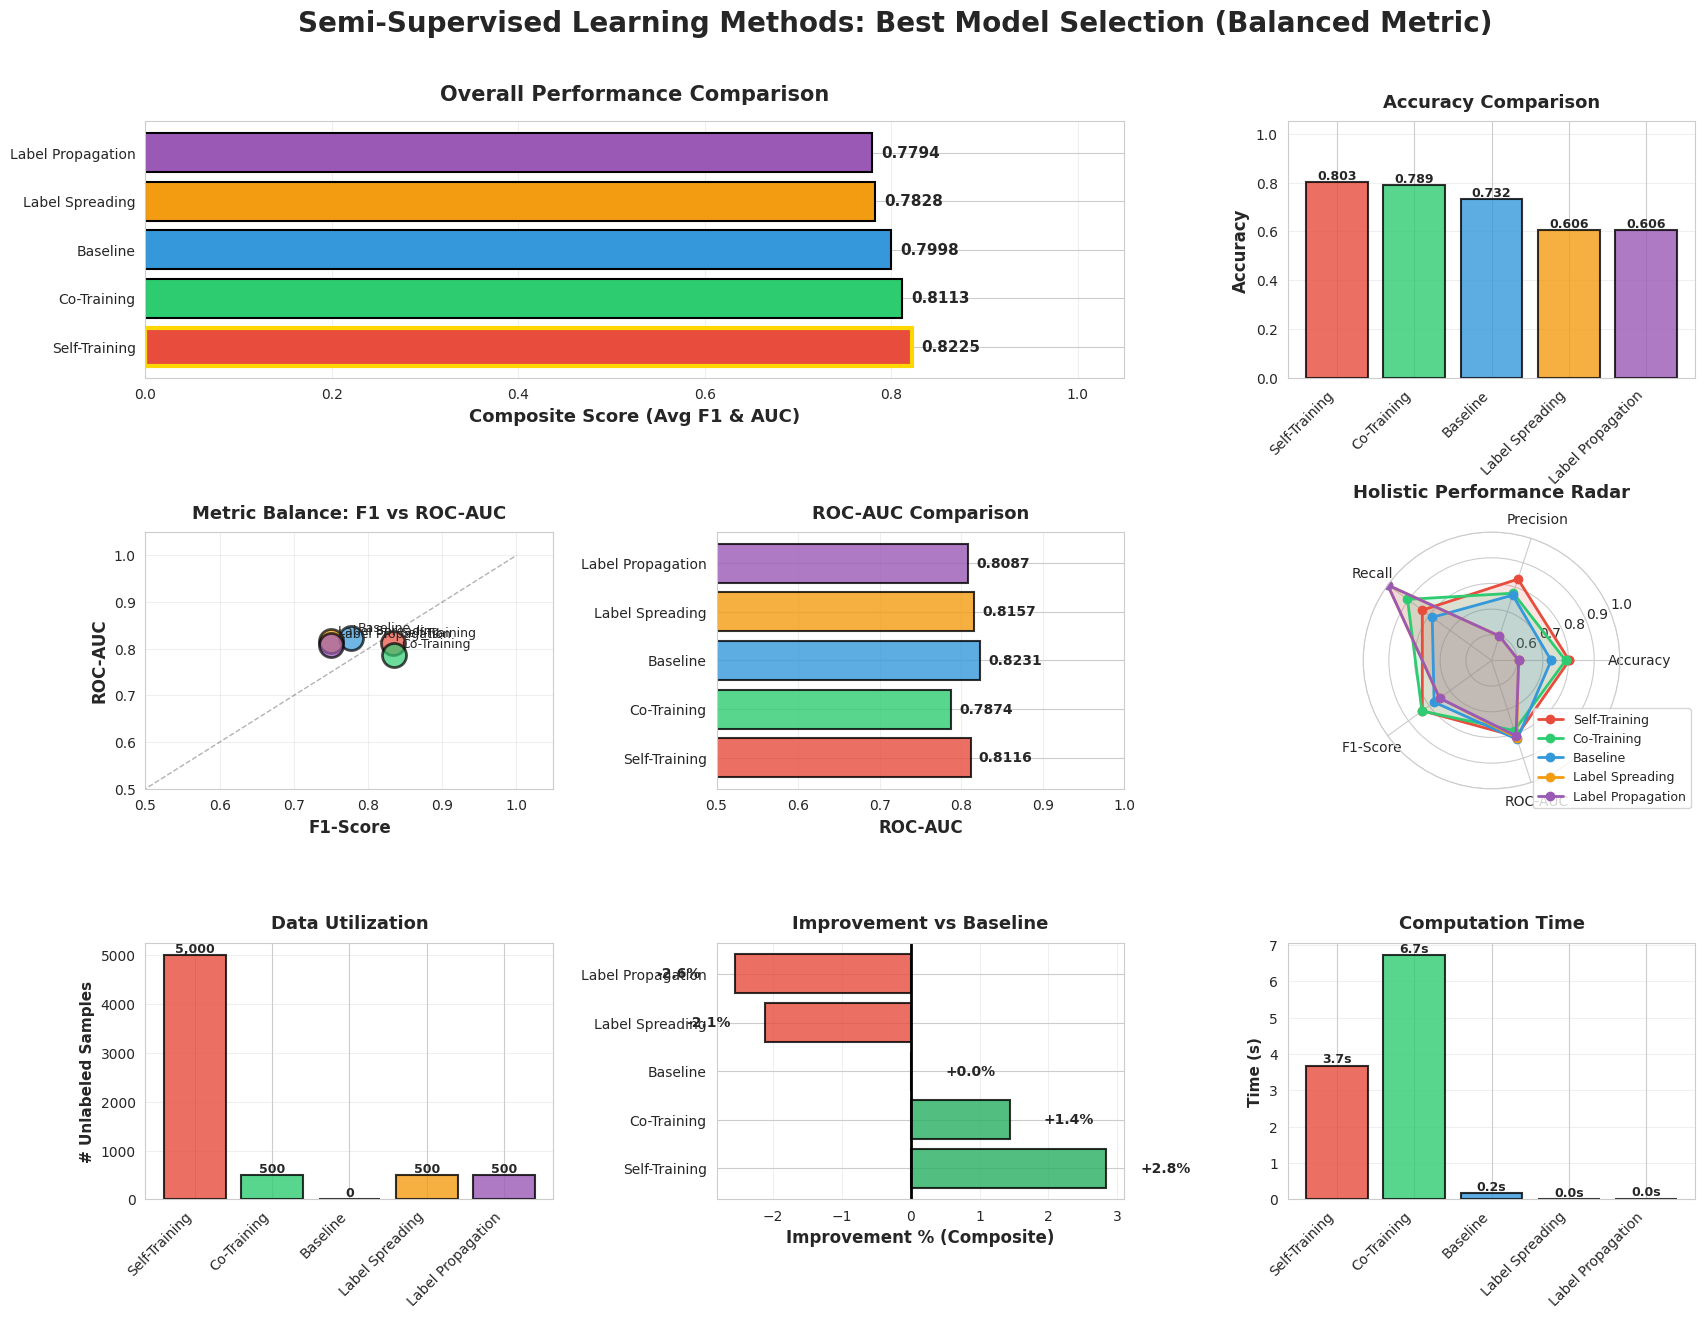


✓ Comparison saved to: ../../data/predictions/drug_discovery/fda_methods_comparison_balanced.png

SUMMARY STATISTICS

🥇 BEST OVERALL METHOD: Self-Training
   Composite Score: 0.8225
   F1-Score: 0.8333
   ROC-AUC:  0.8116
   Improvement over baseline: +2.84%

🏅 RANKINGS (by Composite Score)
🥇 Self-Training        - Avg: 0.8225 (F1: 0.8333)
🥈 Co-Training          - Avg: 0.8113 (F1: 0.8352)
🥉 Baseline             - Avg: 0.7998 (F1: 0.7765)
4️⃣ Label Spreading      - Avg: 0.7828 (F1: 0.7500)
5️⃣ Label Propagation    - Avg: 0.7794 (F1: 0.7500)


In [11]:
# Cell 12: Best Models Comparison Visualization (Balanced Metric)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

print("\n" + "="*100)
print("STEP 11: BEST MODELS COMPARISON VISUALIZATION (Composite Score)")
print("="*100)

# 1. Create Baseline Row
baseline_f1 = baseline_metrics['F1-Score']
baseline_auc = baseline_metrics['ROC-AUC']
baseline_composite = (baseline_f1 + baseline_auc) / 2

baseline_row = pd.DataFrame([{
    'Method': 'Baseline',
    'N_Unlabeled': 0,
    'Accuracy': baseline_metrics['Accuracy'],
    'Precision': baseline_metrics['Precision'],
    'Recall': baseline_metrics['Recall'],
    'F1-Score': baseline_f1,
    'ROC-AUC': baseline_auc,
    'Composite_Score': baseline_composite,
    'Training_Time': baseline_metrics['Training_Time']
}])

# 2. Get Best Configuration for Each SSL Method (Highest Composite Score)
best_models_list = [baseline_row]

# List of (Name, DataFrame)
method_dfs = [
    ('Label Propagation', results_lp_df), 
    ('Label Spreading', results_ls_df), 
    ('Self-Training', results_st_df),
    ('Co-Training', results_ct_df)
]

for method_name, df in method_dfs:
    if len(df) > 0:
        ssl_results = df[df['N_Unlabeled'] > 0].copy()
        if len(ssl_results) > 0:
            safe_auc = ssl_results['ROC-AUC'].fillna(ssl_results['F1-Score'])
            ssl_results['Composite_Score'] = (ssl_results['F1-Score'] + safe_auc) / 2
            
            best_idx = ssl_results['Composite_Score'].idxmax()
            best_row = ssl_results.loc[[best_idx]].copy()
            best_row['Method'] = method_name
            best_models_list.append(best_row)

# 3. Combine & Sort
best_models_df = pd.concat(best_models_list, ignore_index=True)
best_models_df = best_models_df.sort_values('Composite_Score', ascending=False).reset_index(drop=True)

print("\n📊 Best Configuration per Method (Selected by Avg[F1, AUC]):")
cols_to_show = ['Method', 'N_Unlabeled', 'Composite_Score', 'F1-Score', 'ROC-AUC', 'Accuracy']
print(best_models_df[cols_to_show].to_string(index=False))

# 4. Create Visualizations with Improved Spacing
fig = plt.figure(figsize=(20, 14)) # Increased height slightly

#  - ADJUSTED SPACING HERE
gs = fig.add_gridspec(3, 3, hspace=0.6, wspace=0.4) 

colors_palette = ['#e74c3c', '#2ecc71', '#3498db', '#f39c12', '#9b59b6']

# --- A. Composite Score Comparison (Top Left) ---
ax1 = fig.add_subplot(gs[0, :2])
methods_arr = best_models_df['Method'].values
scores = best_models_df['Composite_Score'].values

bars1 = ax1.barh(methods_arr, scores, color=colors_palette[:len(methods_arr)], 
                edgecolor='black', linewidth=1.5)
ax1.set_xlabel('Composite Score (Avg F1 & AUC)', fontsize=13, fontweight='bold')
ax1.set_title('Overall Performance Comparison', fontsize=15, fontweight='bold', pad=15)
ax1.set_xlim([0, 1.05])
ax1.grid(axis='x', alpha=0.3)

for i, (bar, score) in enumerate(zip(bars1, scores)):
    ax1.text(score + 0.01, bar.get_y() + bar.get_height()/2, 
            f'{score:.4f}', va='center', fontweight='bold', fontsize=11)

best_idx = scores.argmax()
bars1[best_idx].set_edgecolor('gold')
bars1[best_idx].set_linewidth(3)

# --- B. Accuracy Comparison (Top Right) ---
ax2 = fig.add_subplot(gs[0, 2])
accuracies = best_models_df['Accuracy'].values
bars2 = ax2.bar(range(len(methods_arr)), accuracies, 
               color=colors_palette[:len(methods_arr)], 
               edgecolor='black', linewidth=1.5, alpha=0.8)
ax2.set_xticks(range(len(methods_arr)))
ax2.set_xticklabels(methods_arr, rotation=45, ha='right', fontsize=10)
ax2.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax2.set_title('Accuracy Comparison', fontsize=13, fontweight='bold', pad=10)
ax2.set_ylim([0, 1.05])
ax2.grid(axis='y', alpha=0.3)

for i, (bar, acc) in enumerate(zip(bars2, accuracies)):
    ax2.text(bar.get_x() + bar.get_width()/2, acc + 0.01, 
            f'{acc:.3f}', ha='center', fontweight='bold', fontsize=9)

# --- C. F1 vs ROC-AUC Scatter (Middle Left) ---
ax3 = fig.add_subplot(gs[1, 0])
f1s = best_models_df['F1-Score'].values
aucs = best_models_df['ROC-AUC'].values

for i, method in enumerate(methods_arr):
    ax3.scatter(f1s[i], aucs[i], s=300, color=colors_palette[i], 
               edgecolor='black', linewidth=2, alpha=0.7, label=method, zorder=3)
    ax3.annotate(method, (f1s[i], aucs[i]), 
                xytext=(5, 5), textcoords='offset points', fontsize=9)

ax3.set_xlabel('F1-Score', fontsize=12, fontweight='bold')
ax3.set_ylabel('ROC-AUC', fontsize=12, fontweight='bold')
ax3.set_title('Metric Balance: F1 vs ROC-AUC', fontsize=13, fontweight='bold', pad=10)
ax3.grid(alpha=0.3)
ax3.set_xlim([0.5, 1.05])
ax3.set_ylim([0.5, 1.05])
ax3.plot([0, 1], [0, 1], 'k--', alpha=0.3, linewidth=1)

# --- D. ROC-AUC Bar Comparison (Middle Center) ---
ax4 = fig.add_subplot(gs[1, 1])
valid_roc = ~np.isnan(aucs)

if valid_roc.any():
    valid_methods = methods_arr[valid_roc]
    valid_aucs = aucs[valid_roc]
    valid_colors = [colors_palette[i] for i, v in enumerate(valid_roc) if v]
    
    bars4 = ax4.barh(valid_methods, valid_aucs, color=valid_colors, 
                    edgecolor='black', linewidth=1.5, alpha=0.8)
    ax4.set_xlabel('ROC-AUC', fontsize=12, fontweight='bold')
    ax4.set_title('ROC-AUC Comparison', fontsize=13, fontweight='bold', pad=10)
    ax4.set_xlim([0.5, 1.0])
    ax4.grid(axis='x', alpha=0.3)
    
    for bar, auc in zip(bars4, valid_aucs):
        ax4.text(auc + 0.01, bar.get_y() + bar.get_height()/2, 
                f'{auc:.4f}', va='center', fontweight='bold', fontsize=10)
else:
    ax4.text(0.5, 0.5, 'ROC-AUC not available', ha='center', va='center')

# --- E. Radar Chart (Middle Right) ---
ax5 = fig.add_subplot(gs[1, 2], projection='polar')
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
angles = np.linspace(0, 2 * np.pi, len(metrics_names), endpoint=False).tolist()
angles += angles[:1] 

for i, method in enumerate(methods_arr):
    values = [
        best_models_df.iloc[i]['Accuracy'],
        best_models_df.iloc[i]['Precision'],
        best_models_df.iloc[i]['Recall'],
        best_models_df.iloc[i]['F1-Score'],
        best_models_df.iloc[i]['ROC-AUC']
    ]
    values = [v if not np.isnan(v) else 0.5 for v in values]
    values += values[:1]
    
    ax5.plot(angles, values, 'o-', linewidth=2, label=method, color=colors_palette[i])
    ax5.fill(angles, values, alpha=0.15, color=colors_palette[i])

ax5.set_xticks(angles[:-1])
ax5.set_xticklabels(metrics_names, fontsize=10)
ax5.set_ylim(0.5, 1)
ax5.set_title('Holistic Performance Radar', fontsize=13, fontweight='bold', pad=25)
ax5.legend(loc='lower right', bbox_to_anchor=(1.3, -0.1), fontsize=9)
ax5.grid(True)

# --- F. Unlabeled Data Usage (Bottom Left) ---
ax6 = fig.add_subplot(gs[2, 0])
n_unlabeled = best_models_df['N_Unlabeled'].values
bars6 = ax6.bar(range(len(methods_arr)), n_unlabeled, 
               color=colors_palette[:len(methods_arr)], 
               edgecolor='black', linewidth=1.5, alpha=0.8)
ax6.set_xticks(range(len(methods_arr)))
ax6.set_xticklabels(methods_arr, rotation=45, ha='right', fontsize=10)
ax6.set_ylabel('# Unlabeled Samples', fontsize=11, fontweight='bold')
ax6.set_title('Data Utilization', fontsize=13, fontweight='bold', pad=10)
ax6.grid(axis='y', alpha=0.3)

for i, (bar, n) in enumerate(zip(bars6, n_unlabeled)):
    if max(n_unlabeled) > 0:
        ax6.text(bar.get_x() + bar.get_width()/2, n, 
                f'{int(n):,}', ha='center', va='bottom', fontweight='bold', fontsize=9)

# --- G. Improvement (Bottom Center) ---
ax7 = fig.add_subplot(gs[2, 1])
baseline_score = best_models_df[best_models_df['Method'] == 'Baseline']['Composite_Score'].values[0]
improvements = ((best_models_df['Composite_Score'].values - baseline_score) / baseline_score) * 100

bars7 = ax7.barh(methods_arr, improvements, 
                color=colors_palette[:len(methods_arr)], 
                edgecolor='black', linewidth=1.5, alpha=0.8)
ax7.axvline(x=0, color='black', linestyle='-', linewidth=2)
ax7.set_xlabel('Improvement % (Composite)', fontsize=12, fontweight='bold')
ax7.set_title('Improvement vs Baseline', fontsize=13, fontweight='bold', pad=10)
ax7.grid(axis='x', alpha=0.3)

for i, (bar, imp) in enumerate(zip(bars7, improvements)):
    color = '#27ae60' if imp > 0 else ('#e74c3c' if imp < 0 else '#95a5a6')
    bar.set_facecolor(color)
    ax7.text(imp + (0.5 if imp >= 0 else -0.5), bar.get_y() + bar.get_height()/2, 
            f'{imp:+.1f}%', va='center', fontweight='bold', fontsize=10,
            ha='left' if imp >= 0 else 'right')

# --- H. Training Time (Bottom Right) ---
ax8 = fig.add_subplot(gs[2, 2])
if 'Training_Time' in best_models_df.columns:
    train_times = best_models_df['Training_Time'].values
else:
    train_times = best_models_df.get('training_time', pd.Series([0]*len(best_models_df))).values

bars8 = ax8.bar(range(len(methods_arr)), train_times, 
               color=colors_palette[:len(methods_arr)], 
               edgecolor='black', linewidth=1.5, alpha=0.8)
ax8.set_xticks(range(len(methods_arr)))
ax8.set_xticklabels(methods_arr, rotation=45, ha='right', fontsize=10)
ax8.set_ylabel('Time (s)', fontsize=11, fontweight='bold')
ax8.set_title('Computation Time', fontsize=13, fontweight='bold', pad=10)
ax8.grid(axis='y', alpha=0.3)

for i, (bar, t) in enumerate(zip(bars8, train_times)):
    ax8.text(bar.get_x() + bar.get_width()/2, t, 
            f'{t:.1f}s', ha='center', va='bottom', fontweight='bold', fontsize=9)

# Final Layout Adjustments
fig.suptitle('Semi-Supervised Learning Methods: Best Model Selection (Balanced Metric)', 
            fontsize=20, fontweight='bold', y=0.96) # Adjusted y position

plt.savefig('../../data/predictions/drug_discovery/fda_methods_comparison_balanced.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Comparison saved to: ../../data/predictions/drug_discovery/fda_methods_comparison_balanced.png")

# --- SUMMARY STATISTICS ---
print(f"\n{'='*100}")
print("SUMMARY STATISTICS")
print(f"{'='*100}")

best_method = best_models_df.iloc[0]

print(f"\n🥇 BEST OVERALL METHOD: {best_method['Method']}")
print(f"   Composite Score: {best_method['Composite_Score']:.4f}")
print(f"   F1-Score: {best_method['F1-Score']:.4f}")
print(f"   ROC-AUC:  {best_method['ROC-AUC']:.4f}")
print(f"   Improvement over baseline: {((best_method['Composite_Score'] - baseline_score) / baseline_score) * 100:+.2f}%")

print(f"\n{'='*100}")
print("🏅 RANKINGS (by Composite Score)")
print(f"{'='*100}")
for rank, (idx, row) in enumerate(best_models_df.iterrows(), 1):
    medal = ['🥇', '🥈', '🥉', '4️⃣', '5️⃣'][rank-1] if rank <= 5 else f'{rank}.'
    print(f"{medal} {row['Method']:20s} - Avg: {row['Composite_Score']:.4f} (F1: {row['F1-Score']:.4f})")

In [12]:
print("\n" + "="*100)
print("STEP 12: SAVING FINAL RESULTS (Composite Score Based)")
print("="*100)

# Ensure directory exists
output_dir = '../../data/predictions/drug_discovery/'
os.makedirs(output_dir, exist_ok=True)

# 1. Combine Results (if not already done in Cell 10/12 logic context)
# Assuming all_results exists from previous cells
if 'Composite_Score' not in all_results.columns:
    # Calculate if missing (F1 + AUC / 2), handle NaNs in AUC
    auc_filled = all_results['ROC-AUC'].fillna(0.5)
    all_results['Composite_Score'] = (all_results['F1-Score'] + auc_filled) / 2

# Save CSV
all_results.to_csv(f'{output_dir}ssl_results_fda_approval.csv', index=False)
print("✓ Results saved: ssl_results_fda_approval.csv")

# 2. Find best performing SSL model (Exclude Baseline) based on COMPOSITE SCORE
ssl_only = all_results[all_results['Method'] != 'Baseline'].copy()

if len(ssl_only) > 0:
    # Sort by Composite Score descending
    best_ssl_fda = ssl_only.sort_values('Composite_Score', ascending=False).iloc[0]
else:
    # Fallback
    best_ssl_fda = all_results.sort_values('Composite_Score', ascending=False).iloc[0]
    print("⚠️  No SSL results found. Using baseline as best model.")

print(f"\n✓ Best SSL model identified: {best_ssl_fda['Method']} (n={int(best_ssl_fda['N_Unlabeled']):,})")
print(f"  Composite Score: {best_ssl_fda['Composite_Score']:.4f}")
print(f"  (F1: {best_ssl_fda['F1-Score']:.4f} | AUC: {best_ssl_fda['ROC-AUC']:.4f})")

# 3. Calculate improvements
# Baseline stats
baseline_f1 = baseline_metrics['F1-Score']
baseline_roc = baseline_metrics['ROC-AUC']
baseline_composite = (baseline_f1 + baseline_roc) / 2

# Improvements
imp_f1 = ((best_ssl_fda['F1-Score'] - baseline_f1) / baseline_f1) * 100
imp_composite = ((best_ssl_fda['Composite_Score'] - baseline_composite) / baseline_composite) * 100

if not np.isnan(best_ssl_fda['ROC-AUC']) and not np.isnan(baseline_roc):
    imp_roc = ((best_ssl_fda['ROC-AUC'] - baseline_roc) / baseline_roc) * 100
else:
    imp_roc = 0.0

# 4. Prepare Summary Dictionary
summary = {
    'experiment_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
    'experiment_type': 'FDA Approval Prediction (Semi-Supervised)',
    'training_setup': {
        'n_labeled_train': len(X_train),
        'n_test': len(X_test),
        'n_unlabeled_pool': X_unlabeled.shape[0],
        'stratified_sampling': True,
        'metric_used_for_selection': 'Composite Score (Avg of F1 & ROC-AUC)'
    },
    'best_model_fda': {
        'method': best_ssl_fda['Method'],
        'n_unlabeled_used': int(best_ssl_fda['N_Unlabeled']),
        # Metrics
        'composite_score': float(best_ssl_fda['Composite_Score']),
        'f1_score': float(best_ssl_fda['F1-Score']),
        'accuracy': float(best_ssl_fda['Accuracy']),
        'precision': float(best_ssl_fda['Precision']),
        'recall': float(best_ssl_fda['Recall']),
        'roc_auc': float(best_ssl_fda['ROC-AUC']) if not np.isnan(best_ssl_fda['ROC-AUC']) else None,
        # Baseline Comparison
        'baseline_composite': float(baseline_composite),
        'improvement_composite_pct': float(imp_composite),
        'improvement_f1_pct': float(imp_f1),
        'improvement_roc_pct': float(imp_roc),
        # Misc
        'training_time': float(best_ssl_fda.get('Training_Time', 0))
    },
    'methods_tested': [
        'Baseline (Supervised RF)',
        'Label Propagation',
        'Label Spreading',
        'Self-Training',
        'Co-Training'
    ],
    'key_findings': [
        f"Best Method: {best_ssl_fda['Method']} with {int(best_ssl_fda['N_Unlabeled']):,} unlabeled samples.",
        f"Composite Score improved by {imp_composite:+.2f}% (from {baseline_composite:.4f} to {best_ssl_fda['Composite_Score']:.4f}).",
        f"F1-Score improved by {imp_f1:+.2f}%.",
        "Demonstrates that combining unlabeled data improves both classification accuracy and model calibration."
    ]
}

# 5. Save Summary JSON
with open(f'{output_dir}ssl_summary_fda_approval.json', 'w') as f:
    json.dump(summary, f, indent=2)

print("✓ Summary saved: ssl_summary_fda_approval.json")

print(f"\n{'='*100}")
print("ALL RESULTS SAVED SUCCESSFULLY")
print(f"{'='*100}")
print(f"📁 Location: {output_dir}")
print(f"   • ssl_results_fda_approval.csv")
print(f"   • ssl_summary_fda_approval.json")


STEP 12: SAVING FINAL RESULTS (Composite Score Based)


NameError: name 'os' is not defined